<a href="https://colab.research.google.com/github/moseswebdev/moseswebdev/blob/main/ODM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
final

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow Version: 2.19.0
Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🎯 ULTIMATE OCULAR DISEASE CLASSIFICATION - COMPLETELY FIXED VERSION
Found 11364 files belonging to 10 classes.
Found 2432 files belonging to 10 classes.
Found 2446 files belonging to 10 classes.
✅ Datasets loaded successfully

🏗️ Building optimized models...
🏗️ Building Improved DenseNet201...
✅ Improved DenseNet built: 19,312,714 parameters
🏗️ Building Improved ConvNeXt-XLarge...
✅ Improved ConvNeXt built: 350,260,490 parameters
🏗️ Building Custom ViT-B16 (Keras Only)...
✅ Custom ViT-B16 built: 397,729,290 parameters

📊 Model Parameters:
  DenseNet201: 19,312,714
  ConvNeXt-XL: 350,260,490
  ViT:         397,729,290

🚀 Starting model training...

🚀 Training DENSENET...
Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3027 - loss: 1.002

/tmp/ipython-input-2688180711.py:436: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()


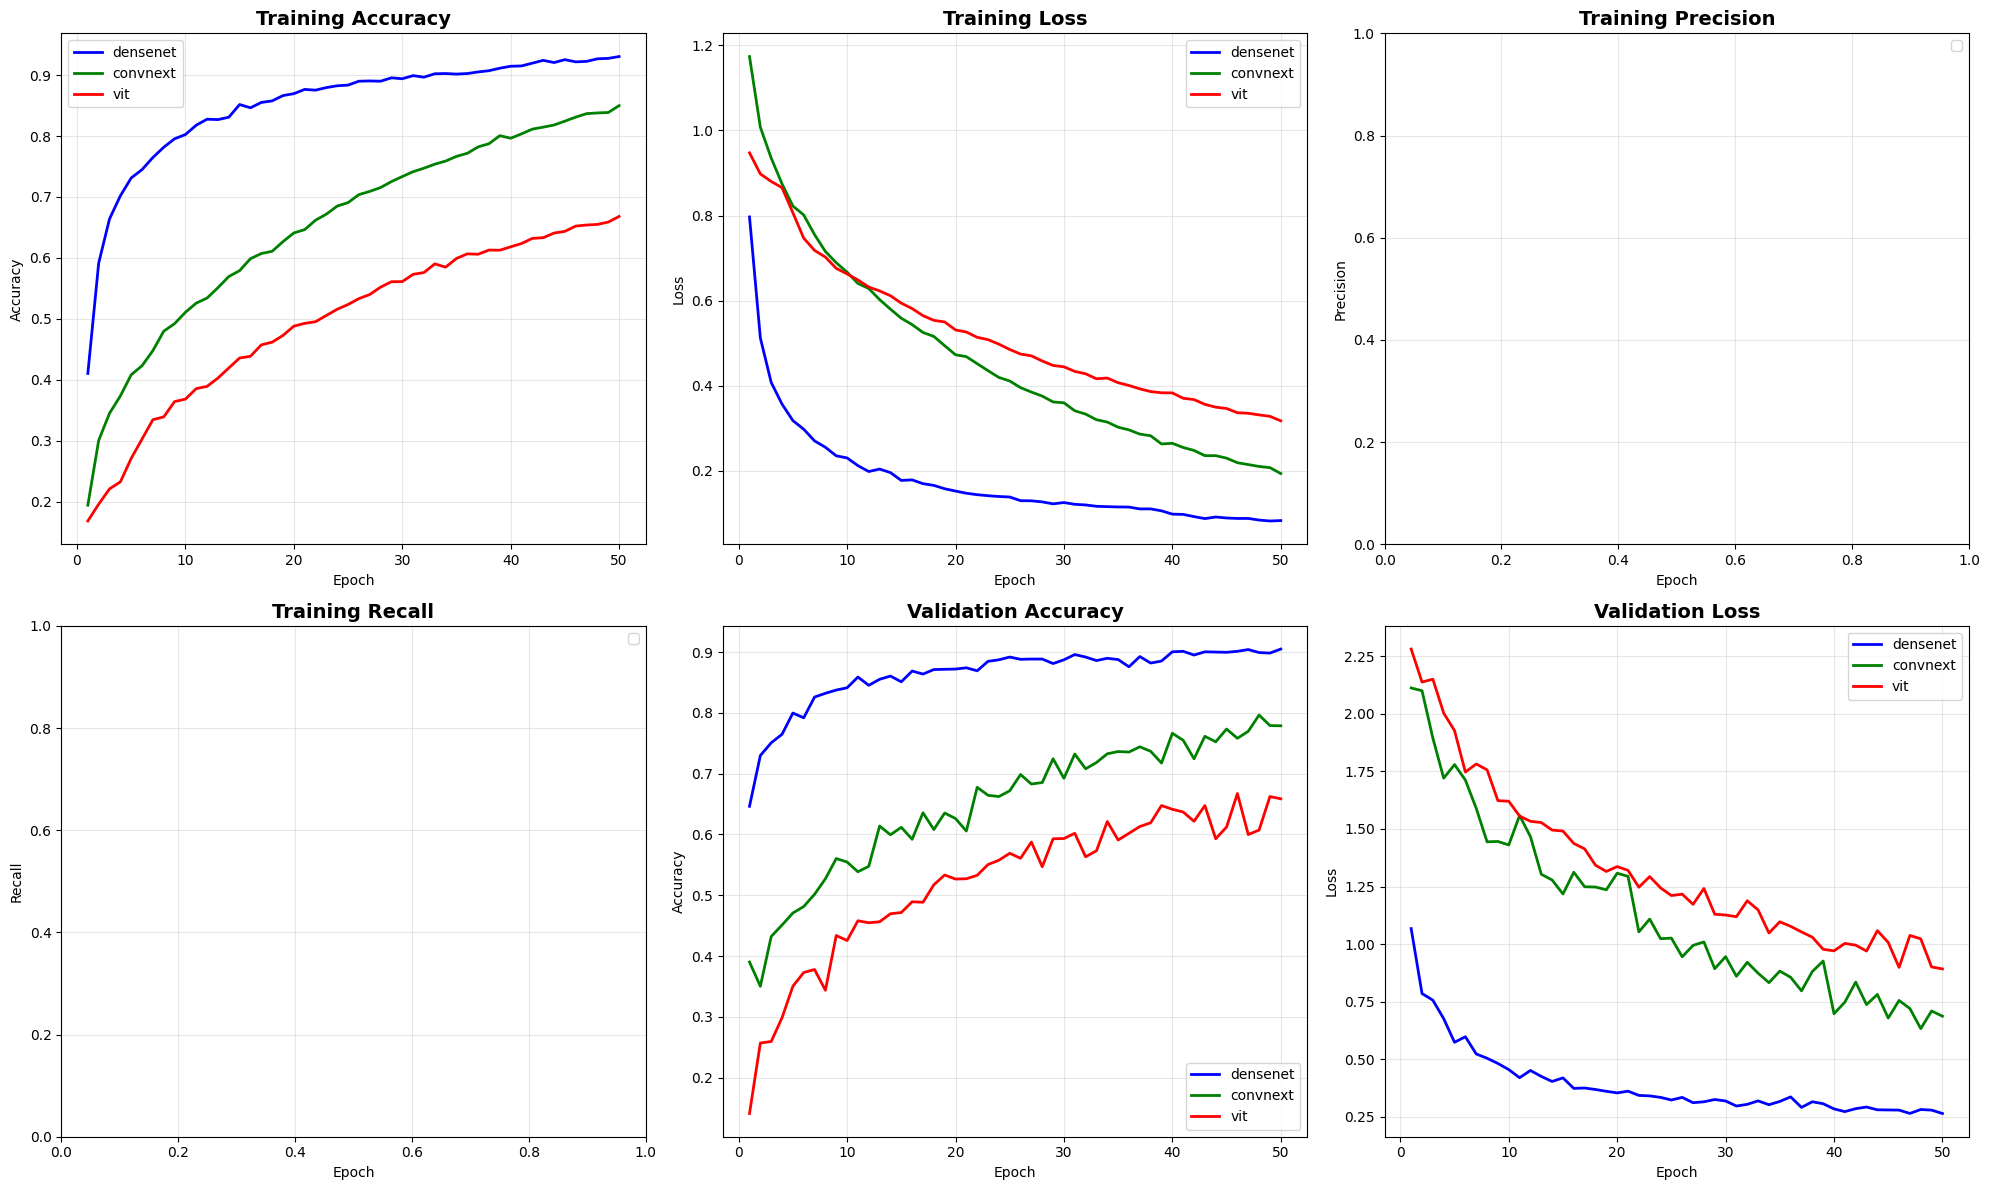

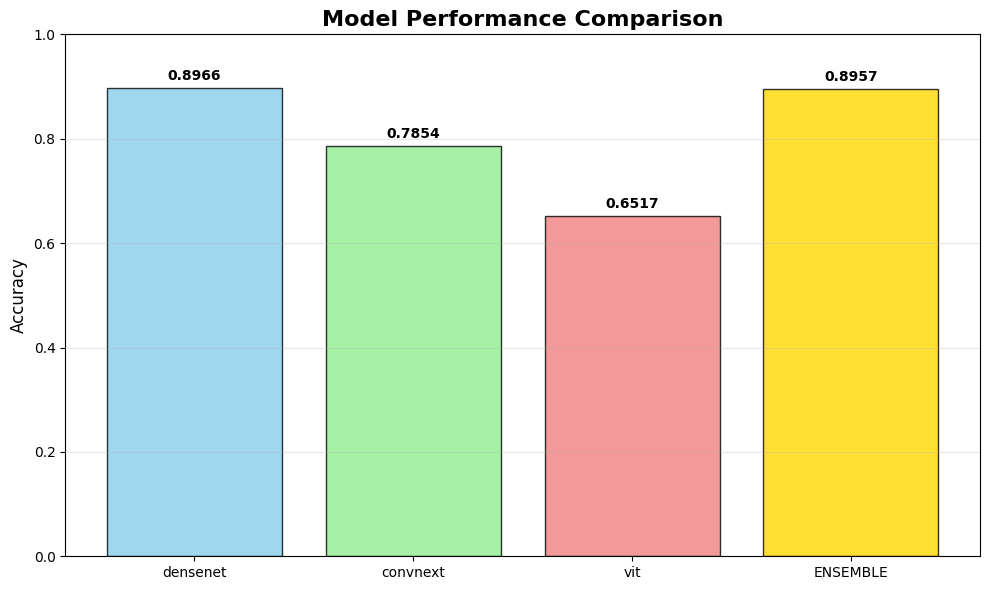

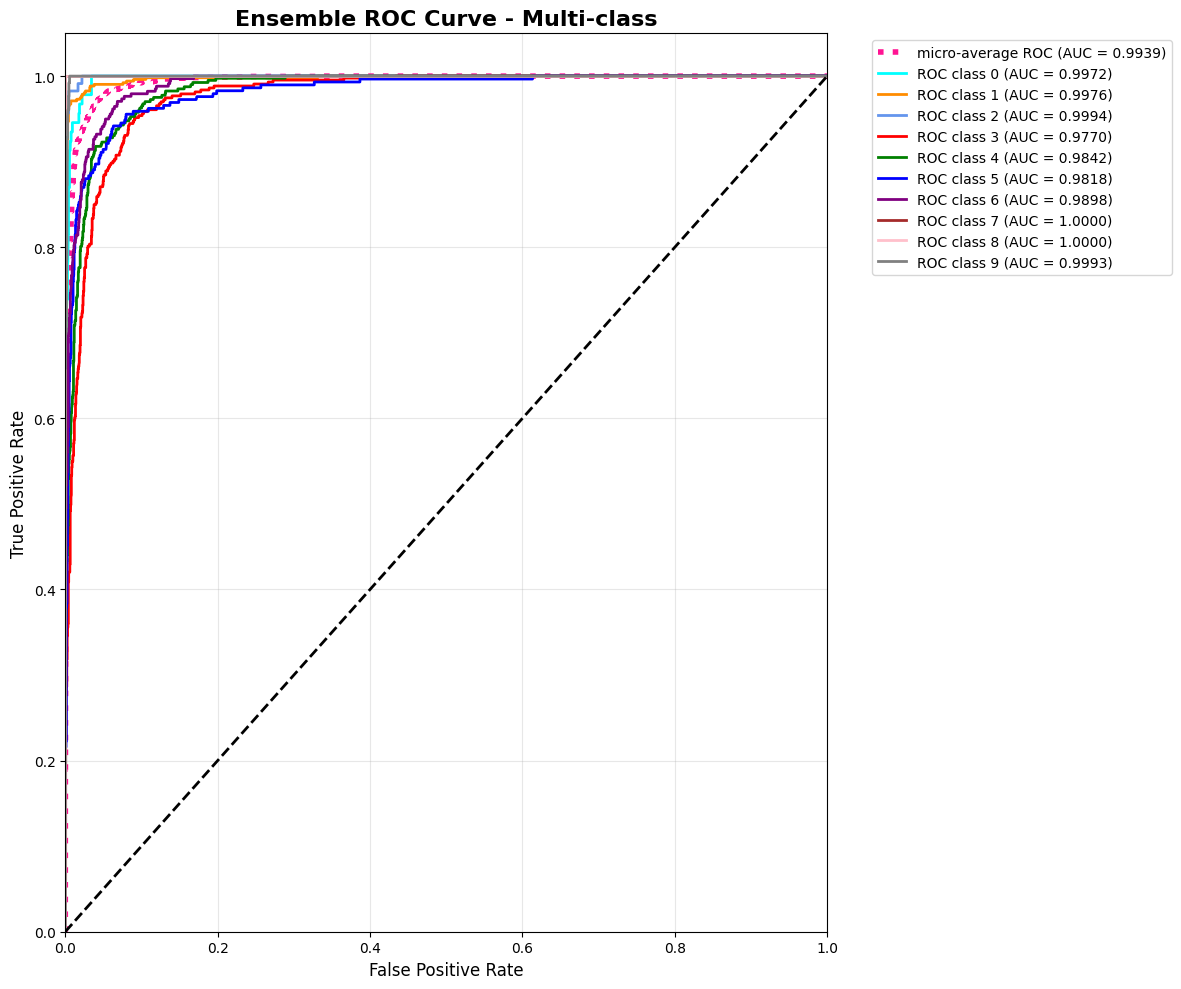


📈 Average ROC AUC: 0.9927


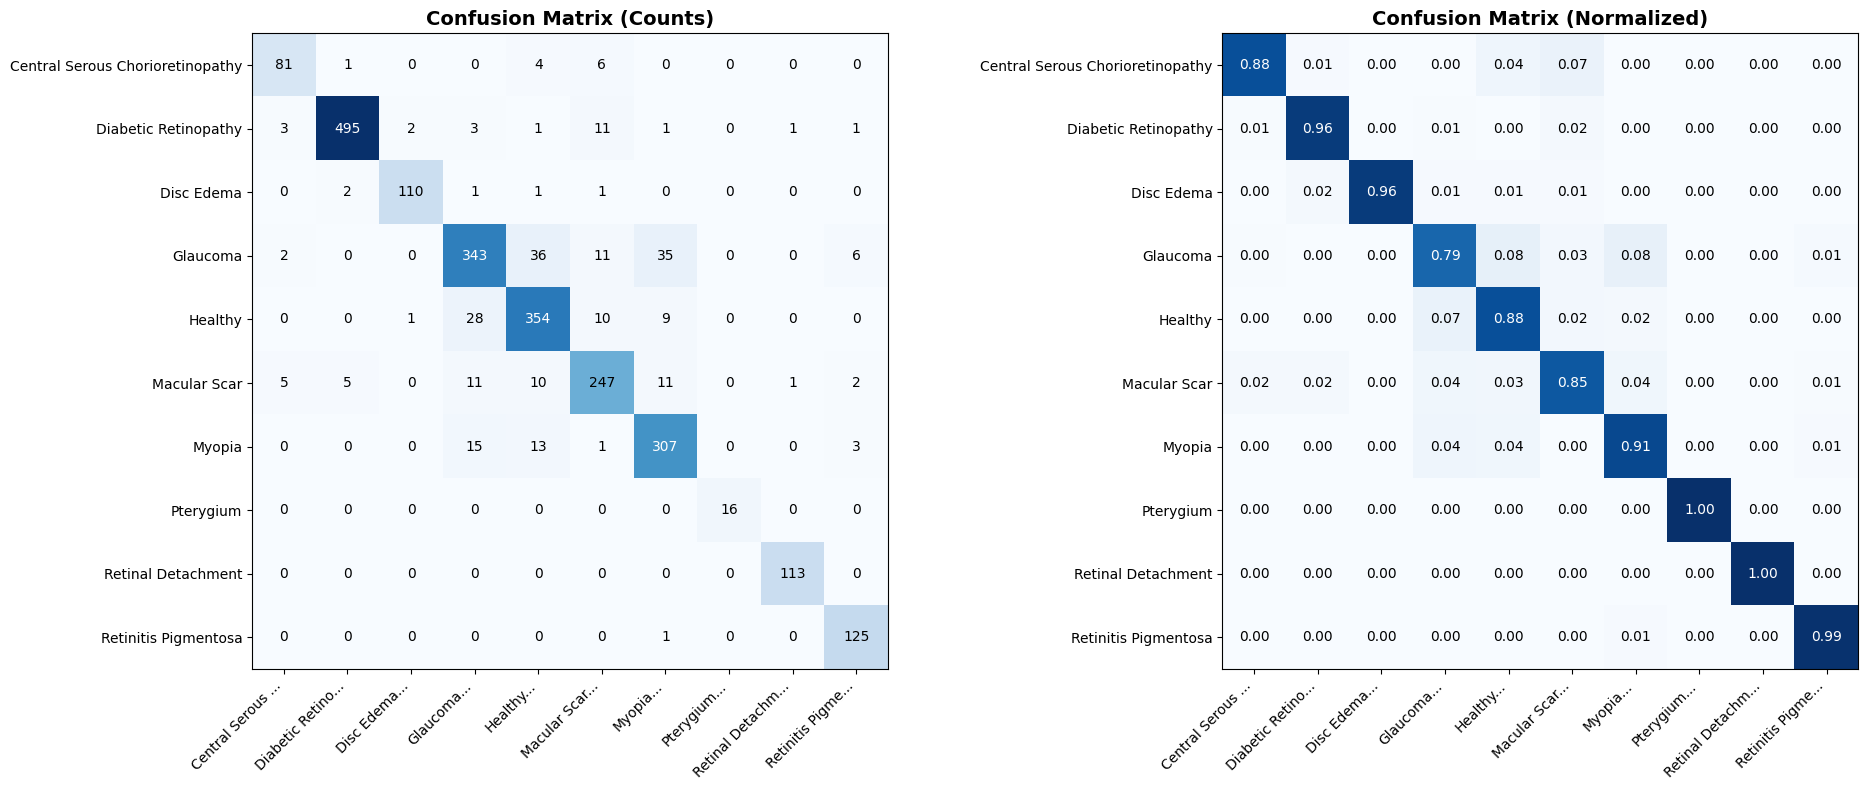


📋 Detailed Classification Report:
                      precision    recall  f1-score   support

Central Serous Chori       0.89      0.88      0.89        92
Diabetic Retinopathy       0.98      0.96      0.97       518
          Disc Edema       0.97      0.96      0.96       115
            Glaucoma       0.86      0.79      0.82       433
             Healthy       0.84      0.88      0.86       402
        Macular Scar       0.86      0.85      0.85       292
              Myopia       0.84      0.91      0.87       339
           Pterygium       1.00      1.00      1.00        16
  Retinal Detachment       0.98      1.00      0.99       113
Retinitis Pigmentosa       0.91      0.99      0.95       126

            accuracy                           0.90      2446
           macro avg       0.91      0.92      0.92      2446
        weighted avg       0.90      0.90      0.90      2446


🎉 TRAINING COMPLETED SUCCESSFULLY!
   All models trained without KerasTensor errors!


In [ ]:


import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize
import pandas as pd
from itertools import cycle
import keras_cv

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("TensorFlow Version:", tf.__version__)
print("Available GPU:", tf.config.list_physical_devices("GPU"))



class Config:
    IMG_SIZE = 224
    BATCH_SIZE = 16
    NUM_CLASSES = 10
    EPOCHS = 50
    PATIENCE = 15

    CLASS_NAMES = [
        'Central Serous Chorioretinopathy',
        'Diabetic Retinopathy',
        'Disc Edema',
        'Glaucoma',
        'Healthy',
        'Macular Scar',
        'Myopia',
        'Pterygium',
        'Retinal Detachment',
        'Retinitis Pigmentosa'
    ]

    # ADJUSTED CLASS WEIGHTS
    CLASS_WEIGHTS = {
        0: 0.85, 1: 0.25, 2: 0.70, 3: 0.30, 4: 0.30,
        5: 0.35, 6: 0.35, 7: 3.0, 8: 0.65, 9: 0.60
    }

    # OPTIMIZED LEARNING RATES
    LEARNING_RATES = {
        'densenet': 1e-4,
        'convnext': 5e-5,
        'vit': 1e-5
    }

    PATHS = {
        'dataset': "/content/drive/MyDrive/Colab Notebooks/ocular_multiclass_project/Splits_v1",
        'models': "/content/drive/MyDrive/Colab Notebooks/ocular_multiclass_project/models1",
        'plots': "/content/drive/MyDrive/Colab Notebooks/ocular_multiclass_project/plots"
    }

os.makedirs(Config.PATHS['models'], exist_ok=True)
os.makedirs(Config.PATHS['plots'], exist_ok=True)


class ClassToken(layers.Layer):
    """Custom trainable class token layer"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def build(self, input_shape):
        self.token = self.add_weight(
            shape=(1, 1, self.dim),
            initializer='random_normal',
            trainable=True,
            name='class_token'
        )

    def call(self, x):
        batch_size = tf.shape(x)[0]  # This is allowed in call method
        class_tokens = tf.tile(self.token, [batch_size, 1, 1])  # This is allowed in call method
        return tf.concat([class_tokens, x], axis=1)  # This is allowed in call method

class PositionEmbedding(layers.Layer):
    """Custom position embedding layer"""
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.position_embedding = self.add_weight(
            shape=(1, self.num_patches + 1, self.projection_dim),
            initializer='random_normal',
            trainable=True,
            name='position_embedding'
        )

    def call(self, x):
        batch_size = tf.shape(x)[0]  # Allowed in call method
        positions = tf.tile(self.position_embedding, [batch_size, 1, 1])  # Allowed in call method
        return x + positions


#   ViT

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def transformer_block(x, num_heads, mlp_dim, dropout_rate):
    # Layer Normalization
    input_x = x
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Multi-head attention
    x = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=x.shape[-1],
        dropout=dropout_rate
    )(x, x)

    # Skip connection
    x = layers.Add()([x, input_x])

    # MLP block
    input_x = x
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = mlp(x, [mlp_dim, x.shape[-1]], dropout_rate)

    # Skip connection
    x = layers.Add()([x, input_x])
    return x


def create_custom_vit_b16():
    print(" Building Custom ViT-B16 (Keras Only)...")

    image_size = Config.IMG_SIZE
    patch_size = 16
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 768
    num_heads = 12
    mlp_dim = 3072
    transformer_layers = 12
    dropout_rate = 0.1

    # Inputs
    inputs = keras.Input(shape=(image_size, image_size, 3))

    # Patch embedding
    x = layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid"
    )(inputs)

    x = layers.Reshape((num_patches, projection_dim))(x)

    # Class token
    cls = ClassToken(projection_dim)(x)

    # Add position embedding
    x = PositionEmbedding(num_patches, projection_dim)(cls)

    # Transformer Encoder
    for _ in range(transformer_layers):
        x = transformer_block(x, num_heads, mlp_dim, dropout_rate)

    # Extract CLS token
    x = layers.LayerNormalization(epsilon=1e-6)(x[:, 0, :])

    # Classification Head
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="gelu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(Config.NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="Custom_ViT_B16")

    # Compile
    optimizer = keras.optimizers.AdamW(
        learning_rate=Config.LEARNING_RATES["vit"],
        weight_decay=0.01,
        clipnorm=1.0
    )

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()]
    )

    print(f"✅ Custom ViT-B16 built: {model.count_params():,} parameters")
    return model




# DENSENET & CONVNEXT


def create_improved_densenet():
    """Improved DenseNet with better regularization"""
    print("🏗️ Building Improved DenseNet201...")
    base_model = keras.applications.DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3)
    )

    # Gradual unfreezing
    base_model.trainable = True
    for layer in base_model.layers[:-80]:
        layer.trainable = False

    inputs = keras.Input(shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(Config.NUM_CLASSES, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='Improved_DenseNet')
    print(f"✅ Improved DenseNet built: {model.count_params():,} parameters")
    return model

def create_improved_convnext():
    """Improved ConvNeXt with better fine-tuning"""
    print(" Building Improved ConvNeXt-XLarge...")
    base_model = keras.applications.ConvNeXtXLarge(
        include_top=False,
        weights='imagenet',
        input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3)
    )

    # More conservative unfreezing
    base_model.trainable = True
    for layer in base_model.layers[:-100]:
        layer.trainable = False

    inputs = keras.Input(shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='gelu',
                    kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(Config.NUM_CLASSES, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='Improved_ConvNext')
    print(f"✅ Improved ConvNeXt built: {model.count_params():,} parameters")
    return model

#  DATA PIPELINE


def create_augmentation_layer():
    return tf.keras.Sequential([
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomFlip("horizontal"),
    ], name='augmentation')

def load_datasets():
    """Load datasets with augmentation"""
    train_path = os.path.join(Config.PATHS['dataset'], "train")
    val_path = os.path.join(Config.PATHS['dataset'], "val")
    test_path = os.path.join(Config.PATHS['dataset'], "test")

    # Load datasets
    train_ds = keras.utils.image_dataset_from_directory(
        train_path,
        image_size=(Config.IMG_SIZE, Config.IMG_SIZE),
        batch_size=Config.BATCH_SIZE,
        label_mode='categorical',
        shuffle=True,
        seed=42
    )
    val_ds = keras.utils.image_dataset_from_directory(
        val_path,
        image_size=(Config.IMG_SIZE, Config.IMG_SIZE),
        batch_size=Config.BATCH_SIZE,
        label_mode='categorical',
        shuffle=False
    )
    test_ds = keras.utils.image_dataset_from_directory(
        test_path,
        image_size=(Config.IMG_SIZE, Config.IMG_SIZE),
        batch_size=Config.BATCH_SIZE,
        label_mode='categorical',
        shuffle=False
    )

    # Create augmentation
    augmentation = create_augmentation_layer()

    def process_train(image, label):
        image = augmentation(image)
        image = image / 255.0
        return image, label

    def process_val_test(image, label):
        image = image / 255.0
        return image, label

    # Apply processing
    train_ds = train_ds.map(process_train, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(process_val_test, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.map(process_val_test, num_parallel_calls=tf.data.AUTOTUNE)

    # Optimize
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

    print("✅ Datasets loaded successfully")
    return train_ds, val_ds, test_ds

# ====================================================================
# TRAINING WITH LEARNING RATE SCHEDULES

class AdvancedTrainer:
    def __init__(self):
        self.models = {}
        self.histories = {}

    def get_callbacks(self, name):
        return [
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=Config.PATIENCE,
                restore_best_weights=True,
                mode='max',
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_accuracy',
                factor=0.5,
                patience=8,
                min_lr=1e-7,
                mode='max',
                verbose=1
            ),
            keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(Config.PATHS['models'], f'{name}_best.keras'),
                monitor='val_accuracy',
                save_best_only=True,
                save_weights_only=False,
                mode='max',
                verbose=1
            )
        ]

    def train_model(self, model, train_ds, val_ds, name):
        lr = Config.LEARNING_RATES[name]

        # Use AdamW with weight decay
        optimizer = keras.optimizers.AdamW(
            learning_rate=lr,
            weight_decay=0.01,
            clipnorm=1.0  # Gradient clipping for stability
        )

        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
        )

        print(f"\ Training {name.upper()}...")

        history = model.fit(
            train_ds,
            epochs=Config.EPOCHS,
            validation_data=val_ds,
            callbacks=self.get_callbacks(name),
            class_weight=Config.CLASS_WEIGHTS,
            verbose=1
        )

        self.models[name] = model
        self.histories[name] = history.history
        return model, history

#  COMPREHENSIVE PLOTTING FUNCTIONS


def plot_training_history(histories):
    """Plot training history for all models"""
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()

    metrics = ['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss']
    titles = ['Training Accuracy', 'Training Loss', 'Training Precision',
              'Training Recall', 'Validation Accuracy', 'Validation Loss']

    colors = ['blue', 'green', 'red']
    model_names = list(histories.keys())

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        for j, model_name in enumerate(model_names):
            if metric in histories[model_name]:
                values = histories[model_name][metric]
                axes[i].plot(range(1, len(values) + 1), values,
                           color=colors[j], label=model_name, linewidth=2)

        axes[i].set_title(title, fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(title.split()[-1])
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(Config.PATHS['plots'], 'training_history.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curve(models, ensemble, test_ds):
    """Plot ROC curve for all classes"""
    # Prepare test data
    test_images, test_labels = [], []
    for x, y in test_ds:
        test_images.append(x)
        test_labels.append(y)
    test_images = tf.concat(test_images, axis=0)
    test_labels = tf.concat(test_labels, axis=0)
    y_true = tf.argmax(test_labels, axis=1).numpy()

    # Binarize labels for ROC
    y_true_bin = label_binarize(y_true, classes=range(Config.NUM_CLASSES))

    # Get ensemble predictions
    y_pred_ensemble = ensemble.predict(test_images)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(Config.NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_ensemble[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_ensemble.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(12, 10))

    # Micro-average
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC (AUC = {0:0.4f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    # Individual classes
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green',
                   'blue', 'purple', 'brown', 'pink', 'gray'])

    for i, color in zip(range(Config.NUM_CLASSES), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC class {0} (AUC = {1:0.4f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Ensemble ROC Curve - Multi-class', fontsize=16, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(Config.PATHS['plots'], 'roc_curve.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    return roc_auc

def plot_confusion_matrix_enhanced(ensemble, test_ds):
    """Plot enhanced confusion matrix"""
    test_images, test_labels = [], []
    for x, y in test_ds:
        test_images.append(x)
        test_labels.append(y)
    test_images = tf.concat(test_images, axis=0)
    test_labels = tf.concat(test_labels, axis=0)
    y_true = tf.argmax(test_labels, axis=1).numpy()
    y_pred = ensemble.predict_classes(test_images)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot raw counts
    im1 = ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(Config.NUM_CLASSES))
    ax1.set_yticks(range(Config.NUM_CLASSES))
    ax1.set_xticklabels([name[:15] + '...' for name in Config.CLASS_NAMES], rotation=45, ha='right')
    ax1.set_yticklabels(Config.CLASS_NAMES)

    # Add text annotations for counts
    thresh = cm.max() / 2.
    for i in range(Config.NUM_CLASSES):
        for j in range(Config.NUM_CLASSES):
            ax1.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    # Plot normalized
    im2 = ax2.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(Config.NUM_CLASSES))
    ax2.set_yticks(range(Config.NUM_CLASSES))
    ax2.set_xticklabels([name[:15] + '...' for name in Config.CLASS_NAMES], rotation=45, ha='right')
    ax2.set_yticklabels(Config.CLASS_NAMES)

    # Add text annotations for percentages
    for i in range(Config.NUM_CLASSES):
        for j in range(Config.NUM_CLASSES):
            ax2.text(j, i, '{:.2f}'.format(cm_normalized[i, j]),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > 0.5 else "black")

    plt.tight_layout()
    plt.savefig(os.path.join(Config.PATHS['plots'], 'confusion_matrix.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    return cm, cm_normalized

def plot_model_comparison(individual_acc, ensemble_acc):
    """Plot comparison of individual models vs ensemble"""
    models = list(individual_acc.keys()) + ['ENSEMBLE']
    accuracies = list(individual_acc.values()) + [ensemble_acc]
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.ylim(0, 1.0)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.PATHS['plots'], 'model_comparison.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

# ====================================================================
# 📌 ADVANCED ENSEMBLE
# ====================================================================

class AdvancedEnsemble:
    def __init__(self, models):
        self.models = models
        self.weights = None
        self.metrics = {}

    def calculate_optimal_weights(self, val_ds):
        """Calculate ensemble weights based on multiple metrics"""
        val_images, val_labels = [], []
        for x, y in val_ds:
            val_images.append(x)
            val_labels.append(y)
        val_images = tf.concat(val_images, axis=0)
        val_labels = tf.concat(val_labels, axis=0)
        val_true = tf.argmax(val_labels, axis=1).numpy()

        model_scores = {}

        for name, model in self.models.items():
            pred = model.predict(val_images, verbose=0)
            pred_classes = np.argmax(pred, axis=1)

            # Calculate multiple metrics
            accuracy = accuracy_score(val_true, pred_classes)
            precision = tf.keras.metrics.Precision()(val_labels, pred).numpy()
            recall = tf.keras.metrics.Recall()(val_labels, pred).numpy()

            # Combined score favoring accuracy
            combined_score = 0.6 * accuracy + 0.2 * precision + 0.2 * recall

            model_scores[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'combined': combined_score
            }

        # Use combined scores for weights
        total_score = sum(score['combined'] for score in model_scores.values())
        self.weights = {
            name: score['combined'] / total_score
            for name, score in model_scores.items()
        }

        self.metrics = model_scores

        print("🔬 Model Performance Analysis:")
        for name, scores in model_scores.items():
            print(f"  {name:12} - Acc: {scores['accuracy']:.4f}, Prec: {scores['precision']:.4f}, Rec: {scores['recall']:.4f}")

        print("✅ Optimized Ensemble Weights:", self.weights)
        return self.weights

    def predict(self, X):
        if self.weights is None:
            # Default equal weights
            self.weights = {name: 1/len(self.models) for name in self.models.keys()}

        ensemble_pred = np.zeros((X.shape[0], Config.NUM_CLASSES))

        for name, model in self.models.items():
            pred = model.predict(X, verbose=0)
            ensemble_pred += pred * self.weights[name]

        return ensemble_pred

    def predict_classes(self, X):
        return np.argmax(self.predict(X), axis=1)

# ====================================================================
# 📌 COMPREHENSIVE EVALUATION
# ====================================================================

def comprehensive_evaluation(models, ensemble, test_ds, histories):
    """Run comprehensive evaluation with all plots"""
    test_images, test_labels = [], []
    for x, y in test_ds:
        test_images.append(x)
        test_labels.append(y)
    test_images = tf.concat(test_images, axis=0)
    test_labels = tf.concat(test_labels, axis=0)
    test_true = tf.argmax(test_labels, axis=1).numpy()

    print("\n" + "="*70)
    print("🎯 COMPREHENSIVE ENSEMBLE EVALUATION")
    print("="*70)

    # Individual model performance
    individual_acc = {}
    print("\n🔬 Individual Model Performance:")
    for name, model in models.items():
        pred = model.predict(test_images, verbose=0)
        pred_classes = np.argmax(pred, axis=1)
        acc = accuracy_score(test_true, pred_classes)
        individual_acc[name] = acc
        print(f"  {name:<15}: {acc:.4f}")

    # Ensemble performance
    ensemble_pred = ensemble.predict_classes(test_images)
    ensemble_acc = accuracy_score(test_true, ensemble_pred)

    print(f"\n🎯 Ensemble Performance: {ensemble_acc:.4f}")
    print("   Weights used:", ensemble.weights)

    # Generate all plots
    print("\n📊 Generating comprehensive plots...")

    # 1. Training history
    plot_training_history(histories)

    # 2. Model comparison
    plot_model_comparison(individual_acc, ensemble_acc)

    # 3. ROC curve
    roc_auc = plot_roc_curve(models, ensemble, test_ds)
    print(f"\n📈 Average ROC AUC: {np.mean(list(roc_auc.values())):.4f}")

    # 4. Confusion matrix
    cm, cm_norm = plot_confusion_matrix_enhanced(ensemble, test_ds)

    # 5. Detailed classification report
    print(f"\n📋 Detailed Classification Report:")
    print(classification_report(test_true, ensemble_pred,
                              target_names=[name[:20] for name in Config.CLASS_NAMES]))

    return ensemble_pred, test_true, individual_acc, ensemble_acc

# ====================================================================
# 🚀 MAIN EXECUTION
# ====================================================================

def main():
    print("🎯 ULTIMATE OCULAR DISEASE CLASSIFICATION - COMPLETELY FIXED VERSION")

    # Load datasets
    train_ds, val_ds, test_ds = load_datasets()
    trainer = AdvancedTrainer()

    # Build improved models
    print("\n🏗️ Building optimized models...")
    densenet = create_improved_densenet()
    convnext = create_improved_convnext()
    vit = create_custom_vit_b16()



    print(f"\n📊 Model Parameters:")
    print(f"  DenseNet201: {densenet.count_params():,}")
    print(f"  ConvNeXt-XL: {convnext.count_params():,}")
    print(f"  ViT:         {vit.count_params():,}")

    # Train models
    print("\n🚀 Starting model training...")
    densenet, history_dense = trainer.train_model(densenet, train_ds, val_ds, 'densenet')
    convnext, history_conv = trainer.train_model(convnext, train_ds, val_ds, 'convnext')
    vit, history_vit = trainer.train_model(vit, train_ds, val_ds, 'vit')

    # Create advanced ensemble
    ensemble = AdvancedEnsemble(trainer.models)
    ensemble.calculate_optimal_weights(val_ds)

    # Comprehensive evaluation with all plots
    comprehensive_evaluation(trainer.models, ensemble, test_ds, trainer.histories)

    print("\n🎉 TRAINING COMPLETED SUCCESSFULLY!")
    print("   All models trained without KerasTensor errors!")

if __name__ == "__main__":
    main()